In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import random
from statsmodels.stats.power import tt_ind_solve_power

def date_converter(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

Срок выполнения задания: 17 марта 17:00.


### Задание
Вам предстоит разработать дизайн эксперимента по тестированию монетизационных продуктов.
В конечном счёте, в монтизационных продуктах нас всегда интересует увеличение выручки, 
но к сожалению не всегда мы можем зафиксировать изменение именно этой метрики.

#### Кейс
Вы аналитик в продуктовой дискавери команде.
На текущий момент приближается начало нового квартала и вам необходимо спланировать
эксперименты в нём.

У вас есть два продукта:
- один базовый продукт, который предоставляет минимальный набор услуг на вашем ресурсе;
- один продвинутый продукт, который предоставляет расширенный набор услуг.

На текущий момент на квартал у вашей команды есть для проверки две гипотезы:
- Дополнительное информирование об эффективности услуг будет стимулировать их покупку;
- Повышение цены базового продукта должно стимулировать покупку продвинутого продукта


#### Для планирования эксперимента изучите данные и метрики (2 балла):

- Загрузите файл и изучите данные;
- Подумайте над тем, какие метрики можно выделить на основе этих данных: выручка, пользователи, транзакции, средний чек и т.д.
- Постройте графики плотности распределения для этих метрик и сделайте выводы о характере распределений: тип, наличие выбросов, насколько сильный разброс;
- Изучите основные статистики этих метрик: среднее, стандартное отклонение;
- Изучите то, насколько эти статистики подвержены сезональности.


#### Формализуйте гипотезы (4 балла):

- Опишите метрики и статистики, изменение которых вы ожидаете;
- Предположите какое относительное изменение этих статистик в процентах вы ожидаете.

#### Предскажите минимально детектируемый эффект для своих метрик и спланируйте эксперименты внутри квартала (4 балла):

- Принимая в расчёт максимально возможные размеры групп и ограничения по длительности в квартал рассмотрите разные планы проведения тестов и предскажите их чувствительность;
- Определите наиболее оптимальный план экспериментов. Обоснуйте, почему вы его считаете оптимальным.


#### * Оптимизация плана (2 балла):
Предложите варианты ускорения экспериментов — всегда могут образоваться ситуации, когда ваши гипотезы не подтвердились и они требуют изменения или уточнения и необходимости повторных тестов. Цели достигать всегда хорошо в рамках отведённого на них срока. Какие параметры экспериментов вы поменяете? К каким последствиям могут привести такие изменения?

#### Описание данныx

event_date - дата 

user_id - идентификатор пользователя

product - тип продукта

amount - сумма покупок

transactions - количество транзакций


### Решение

In [2]:
df = pd.read_csv('user_transactions.csv')
df['event_date'] = df.event_date.apply(date_converter)

In [3]:
df.tail()

,event_date,user_id,product,amount,transactions
1278181,2020-12-29,9175681616034416929,advanced,679.0,1
1278182,2020-12-29,9190225485662720178,advanced,439.0,1
1278183,2020-12-29,9192452502210580022,basic,149.0,1
1278184,2020-12-29,9202424686732081420,basic,947.0,3
1278185,2020-12-29,9219633945080038962,basic,79.0,1


Метрики, которые можно рассчитать по данным (их очень много, вот основные):
  - выручка: GMV (объем суммарных продаж), среднее значение суммы покупок за период или по пользователям;
  - пользователи: общее количество уникальных пользователей, количество активных пользователей (DAU/WAU/MAU);
  - транзакции: среднее число транзакций за период или по пользователям;
  - средний чек: средний чек за период или по пользователям;
  - retention за период;
  - доля покупок продвинутого продукта среди общий продаж.

In [526]:
# общий GMV
df.amount.sum()

306076738.0

In [527]:
# Число уникальных пользователей 
len(df.user_id.unique())

446935

In [4]:
df['average_user_check'] = df.amount / df.transactions
df.tail()

,event_date,user_id,product,amount,transactions,average_user_check
1278181,2020-12-29,9175681616034416929,advanced,679.0,1,679.000000
1278182,2020-12-29,9190225485662720178,advanced,439.0,1,439.000000
1278183,2020-12-29,9192452502210580022,basic,149.0,1,149.000000
1278184,2020-12-29,9202424686732081420,basic,947.0,3,315.666667
1278185,2020-12-29,9219633945080038962,basic,79.0,1,79.000000


In [5]:
df['event_date_month'] = pd.to_datetime(df['event_date'],infer_datetime_format=True)
df['event_date_month'] = df['event_date_month'].dt.strftime('%Y-%m') 
df.tail()

,event_date,user_id,product,amount,transactions,average_user_check,event_date_month
1278181,2020-12-29,9175681616034416929,advanced,679.0,1,679.000000,2020-12
1278182,2020-12-29,9190225485662720178,advanced,439.0,1,439.000000,2020-12
1278183,2020-12-29,9192452502210580022,basic,149.0,1,149.000000,2020-12
1278184,2020-12-29,9202424686732081420,basic,947.0,3,315.666667,2020-12
1278185,2020-12-29,9219633945080038962,basic,79.0,1,79.000000,2020-12


In [7]:
d = df.groupby('event_date', as_index=False).mean()
d.drop('user_id', axis=1, inplace=True)
d

,event_date,amount,transactions,average_user_check
0,2020-09-29,234.809598,1.255263,188.501298
1,2020-09-30,237.204125,1.273430,186.884191
2,2020-10-01,235.122807,1.273315,185.836581
3,2020-10-02,239.040108,1.329767,182.727140
4,2020-10-03,217.609838,1.259279,175.887875
...,...,...,...,...
87,2020-12-25,245.577311,1.324511,187.183081
88,2020-12-26,223.032988,1.281547,176.425733
89,2020-12-27,219.983181,1.262889,173.692813
90,2020-12-28,246.983926,1.310053,188.750404


Построим графики плотности распределений:

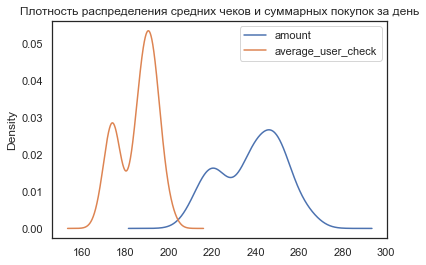

In [532]:
d[['amount', 'average_user_check']].plot.kde(title='Плотность распределения средних чеков и суммарных покупок за день');

Замечаем, что распределение средних чеков и суммарных покупок за день имеет бимодальный вид. это может быть вызвано тем, что у нас имеется 2 вида продукта, или некоторой сезонностью (надо проверять). К тому же, видно, что у распределения средних чеков разброс меньше, чем у числа суммарных покупок (чек меньше шумит). 

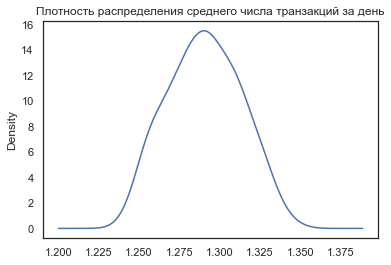

In [533]:
d['transactions'].plot.kde(title='Плотность распределения среднего числа транзакций за день');

Распределение же числа среднего числа транзакций за день имеет уже унимодальное вид (колокол) и сравнительно небольшой разброс.

Посмотрим, есть ли аномалии - построим точечные графики:

Text(0.5, 1.0, 'transactions')

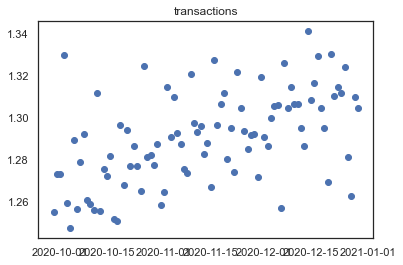

In [534]:
plt.scatter(d['event_date'], d['transactions']);
plt.title('transactions')

Text(0.5, 1.0, 'average_user_check')

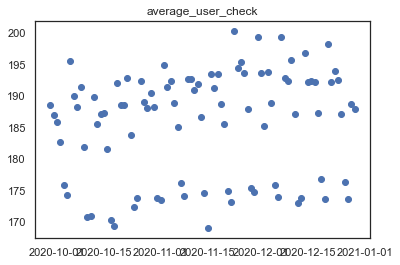

In [535]:
plt.scatter(d['event_date'], d['average_user_check']);
plt.title('average_user_check')

Text(0.5, 1.0, 'amount')

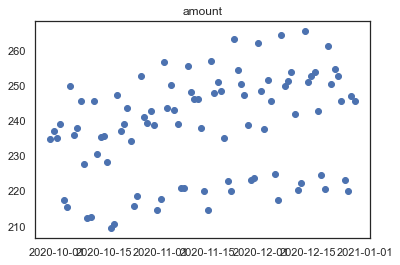

In [537]:
plt.scatter(d['event_date'], d['amount']);
plt.title('amount')

Таким образом, видим, что выбросов у нас нет.

Теперь попробуем отследить сезонность - построим графики временных рядов:

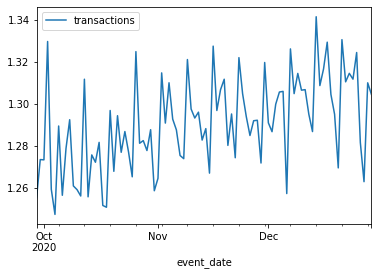

In [13]:
d.plot(x='event_date', y=['transactions']);

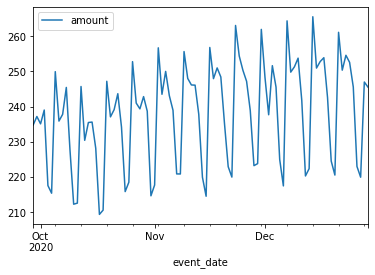

In [14]:
d.plot(x='event_date', y=['amount']);

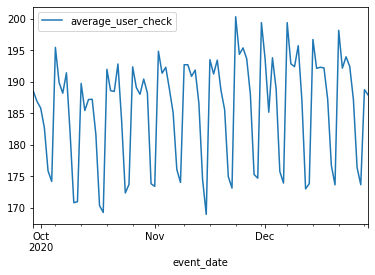

In [15]:
d.plot(x='event_date', y=['average_user_check']);

Таким образом, замечаем недельную сезонность для суммарных покупок и среднего чека (в выходные у нас покупают меньше) - этим можно объснить бимодальность их распределений. Для транзакций выделить явную сезонность не получается (много шума).

Последим также за активными пользователями:

In [16]:
d_counts = df.groupby('event_date', as_index=False).count()
d_counts = d_counts[['event_date', 'user_id']]
d_counts.head()

,event_date,user_id
0,2020-09-29,12920
1,2020-09-30,13722
2,2020-10-01,12996
3,2020-10-02,13364
4,2020-10-03,11262


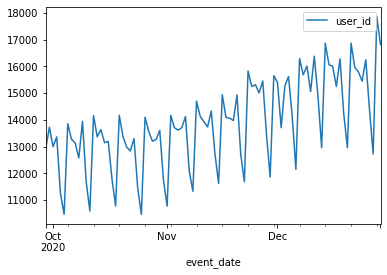

In [17]:
d_counts.plot(x='event_date', y=['user_id']);

Замечаем также недельную сезонность. К тому же виден тренд к росту активных пользователей.

In [18]:
df.head()

,event_date,user_id,product,amount,transactions,average_user_check,event_date_month
0,2020-09-29,40746820883461494,basic,95.0,1,95.0,2020-09
1,2020-09-29,41102328408008828,advanced,279.0,1,279.0,2020-09
2,2020-09-29,63464894315144075,basic,64.0,1,64.0,2020-09
3,2020-09-29,111526991873455341,basic,399.0,1,399.0,2020-09
4,2020-09-29,169522572963414231,basic,199.0,1,199.0,2020-09


In [19]:
d_month = df.groupby(['event_date_month', 'user_id']).sum()
d_month

amount  transactions  average_user_check
event_date_month user_id                                                      
2020-09          333739223557249        60.0             1                60.0
                 643775396628845        69.0             1                69.0
                 884315328624338      2868.0             2              1434.0
                 970398081171047        69.0             1                69.0
                 1309635434849784       12.0             1                12.0
...                                      ...           ...                 ...
2020-12          9223239677152577298    79.0             1                79.0
                 9223275437355872679   590.0             1               590.0
                 9223341083512664945    89.0             1                89.0
                 9223361693694781577    79.0             1                79.0
                 9223366785772814828   469.0             1               469.0

[606945 rows x 3 columns]

In [20]:
d_month = d_month.groupby('event_date_month').mean()
d_month

,amount,transactions,average_user_check
event_date_month,,,
2020-09,260.777732,1.397139,207.334092
2020-10,494.911312,2.715744,391.469769
2020-11,521.154515,2.797228,404.385427
2020-12,525.654830,2.814033,404.766144


### Базовый продукт

Так как у нас есть 2 вида продукта, логично посмотреть эти метрики в их разрезах. Начнем с базового продукта:

In [21]:
df_b = df[df['product'] == 'basic']
df_b.head()

,event_date,user_id,product,amount,transactions,average_user_check,event_date_month
0,2020-09-29,40746820883461494,basic,95.0,1,95.0,2020-09
2,2020-09-29,63464894315144075,basic,64.0,1,64.0,2020-09
3,2020-09-29,111526991873455341,basic,399.0,1,399.0,2020-09
4,2020-09-29,169522572963414231,basic,199.0,1,199.0,2020-09
5,2020-09-29,198859200434938543,basic,89.0,1,89.0,2020-09


In [22]:
d_b = df_b.groupby('event_date', as_index=False).mean()
d_b.drop('user_id', axis=1, inplace=True)
d_b.head()

,event_date,amount,transactions,average_user_check
0,2020-09-29,164.455340,1.261831,131.835358
1,2020-09-30,166.385550,1.277694,131.656746
2,2020-10-01,164.122970,1.274356,130.577649
3,2020-10-02,174.004299,1.347091,130.827750
4,2020-10-03,157.260145,1.270460,126.610084


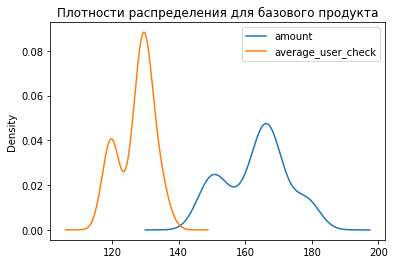

In [23]:
d_b[['amount', 'average_user_check']].plot.kde(title='Плотности распределения для базового продукта');

Бимодальность характерна для суммарных покупок и среднего чека и базового продукта.

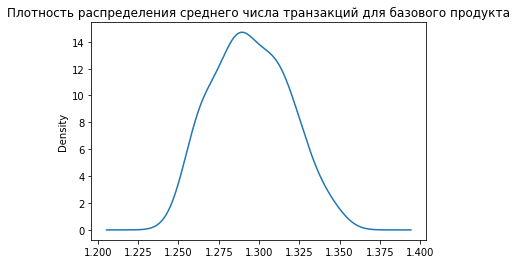

In [24]:
d_b['transactions'].plot.kde(title='Плотность распределения среднего числа транзакций для базового продукта');

Распределение транзакций также унимодально.

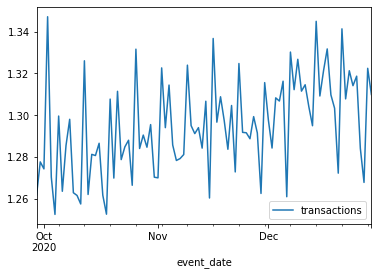

In [25]:
d_b.plot(x='event_date', y=['transactions']);

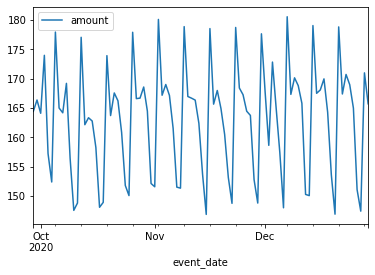

In [26]:
d_b.plot(x='event_date', y=['amount']);

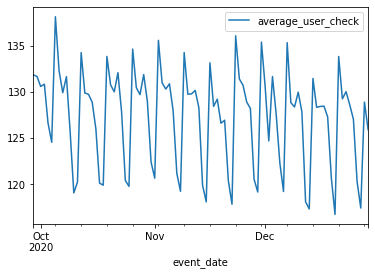

In [27]:
d_b.plot(x='event_date', y=['average_user_check']);

In [30]:
d_b_counts = df_b.groupby('event_date', as_index=False).count()[['event_date', 'user_id']]
d_b_counts.head()

,event_date,user_id
0,2020-09-29,9953
1,2020-09-30,10616
2,2020-10-01,10100
3,2020-10-02,10467
4,2020-10-03,8822


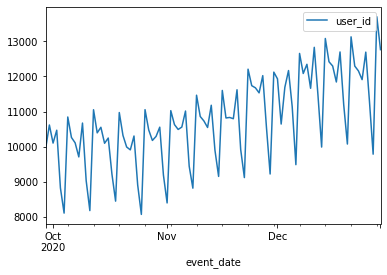

In [31]:
d_b_counts.plot(x='event_date', y=['user_id']);

Недельная сезонность также хорошо видна.

### Продвинутый продукт

Теперь взглянем на метрики продвинутого продукта:

In [32]:
df_a = df[df['product'] == 'advanced']
df_a.head()

,event_date,user_id,product,amount,transactions,average_user_check,event_date_month
1,2020-09-29,41102328408008828,advanced,279.0,1,279.0,2020-09
9,2020-09-29,314919079237057602,advanced,280.0,1,280.0,2020-09
10,2020-09-29,344289654228596611,advanced,440.0,1,440.0,2020-09
14,2020-09-29,494079113546693695,advanced,229.0,1,229.0,2020-09
16,2020-09-29,515550254542076672,advanced,299.0,1,299.0,2020-09


In [33]:
d_a = df_a.groupby('event_date', as_index=False).mean()
d_a.drop('user_id', axis=1, inplace=True)
d_a.head()

,event_date,amount,transactions,average_user_check
0,2020-09-29,470.817661,1.233232,378.590986
1,2020-09-30,479.254990,1.258854,375.646120
2,2020-10-01,482.739641,1.269682,378.555922
3,2020-10-02,474.017604,1.267173,370.242126
4,2020-10-03,435.808607,1.218852,354.055362


<AxesSubplot:title={'center':'Плотности распределения для продвинутого продукта'}, ylabel='Density'>

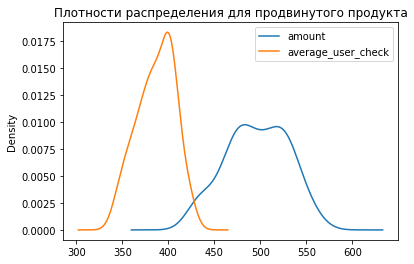

In [34]:
d_a[['amount', 'average_user_check']].plot.kde(title='Плотности распределения для продвинутого продукта')

Здесь уже не так хорошо просматривается бимодальность распределений (скорее всего мало данных).

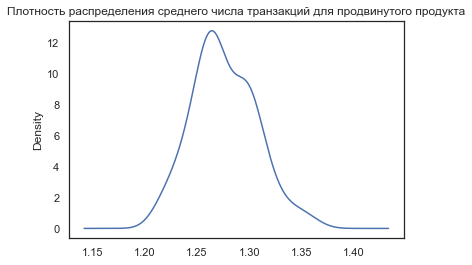

In [540]:
d_a['transactions'].plot.kde(title='Плотность распределения среднего числа транзакций для продвинутого продукта');

Распределение транзакций "искривилось".

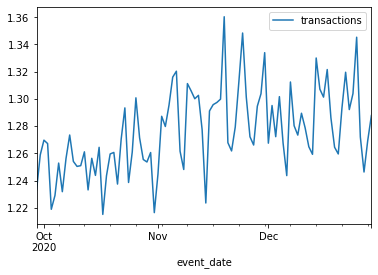

In [36]:
d_a.plot(x='event_date', y=['transactions']);

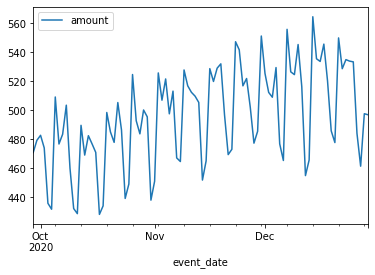

In [37]:
d_a.plot(x='event_date', y=['amount']);

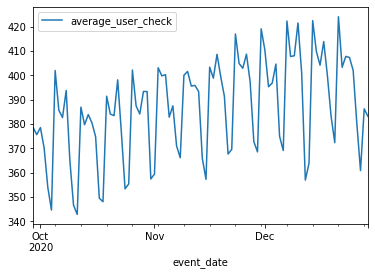

In [38]:
d_a.plot(x='event_date', y=['average_user_check']);

In [39]:
d_a_counts = df_a.groupby('event_date', as_index=False).count()[['event_date', 'user_id']]
d_a_counts.head()

,event_date,user_id
0,2020-09-29,2967
1,2020-09-30,3106
2,2020-10-01,2896
3,2020-10-02,2897
4,2020-10-03,2440


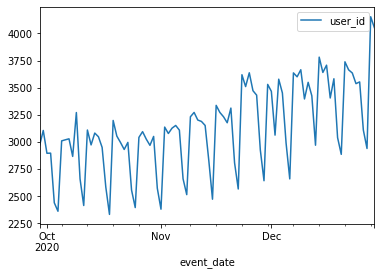

In [40]:
d_a_counts.plot(x='event_date', y=['user_id']);

Взглянем какую долю занимает продвинутый продукт в нашем бизнесе (по пользователям, транзакциям, суммарным покупкам):

In [41]:
advanced_proportion_users = pd.DataFrame()
advanced_proportion_users['event_date'] = d['event_date']
advanced_proportion_users['proportion'] = d_a_counts['user_id'] / (d_a_counts['user_id'] + d_b_counts['user_id'])
advanced_proportion_users.head()

,event_date,proportion
0,2020-09-29,0.229644
1,2020-09-30,0.226352
2,2020-10-01,0.222838
3,2020-10-02,0.216776
4,2020-10-03,0.216658


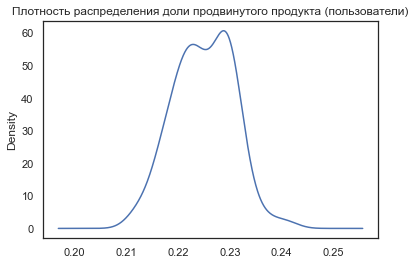

In [541]:
advanced_proportion_users['proportion'].plot.kde(title='Плотность распределения доли продвинутого продукта (пользователи)');

Видим, что ежедневных пользователей не так много (около 22-23%).

In [44]:
d_a_sums = df_a.groupby('event_date', as_index=False).sum()
d_a_sums.drop('user_id', axis=1, inplace=True)
d_a_sums.head()

,event_date,amount,transactions,average_user_check
0,2020-09-29,1396916.0,3659.0,1.123279e+06
1,2020-09-30,1488566.0,3910.0,1.166757e+06
2,2020-10-01,1398014.0,3677.0,1.096298e+06
3,2020-10-02,1373229.0,3671.0,1.072591e+06
4,2020-10-03,1063373.0,2974.0,8.638951e+05


In [45]:
d_b_sums = df_b.groupby('event_date', as_index=False).sum()
d_b_sums.drop('user_id', axis=1, inplace=True)
d_b_sums.head()

,event_date,amount,transactions,average_user_check
0,2020-09-29,1636824.0,12559.0,1.312157e+06
1,2020-09-30,1766349.0,13564.0,1.397668e+06
2,2020-10-01,1657642.0,12871.0,1.318834e+06
3,2020-10-02,1821303.0,14100.0,1.369374e+06
4,2020-10-03,1387349.0,11208.0,1.116954e+06


In [46]:
advanced_proportion_transactions = pd.DataFrame()
advanced_proportion_transactions['event_date'] = d['event_date']
advanced_proportion_transactions['proportion'] = d_a_sums['transactions'] / (d_a_sums['transactions'] + d_b_sums['transactions'])
advanced_proportion_transactions.head()

,event_date,proportion
0,2020-09-29,0.225614
1,2020-09-30,0.223761
2,2020-10-01,0.222202
3,2020-10-02,0.206573
4,2020-10-03,0.209702


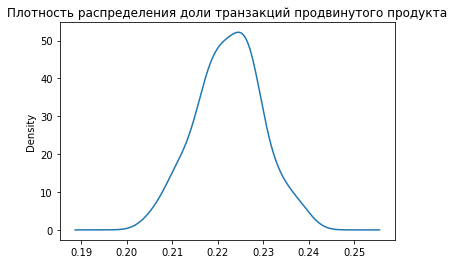

In [47]:
advanced_proportion_transactions['proportion'].plot.kde(title='Плотность распределения доли транзакций продвинутого продукта');

Видим похожую картину и по транзакциям (их около 22-23% от общего числа).

In [49]:
advanced_proportion_amounts = pd.DataFrame()
advanced_proportion_amounts['event_date'] = d['event_date']
advanced_proportion_amounts['proportion'] = d_a_sums['amount'] / (d_a_sums['amount'] + d_b_sums['amount'])
advanced_proportion_amounts.head()

,event_date,proportion
0,2020-09-29,0.460460
1,2020-09-30,0.457329
2,2020-10-01,0.457517
3,2020-10-02,0.429869
4,2020-10-03,0.433902


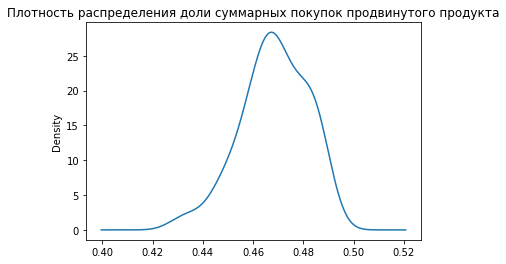

In [50]:
advanced_proportion_amounts['proportion'].plot.kde(title='Плотность распределения доли суммарных покупок продвинутого продукта');

А вот суммарные покупки по продвинутому продукту составляют практически половину всего нашего оборота.

### Retention

Взглянем, как хорошо пользователи возвращаются к нам (рассмотрим месячный retention). Это будет не очень честно, так как не обязательно, что первая покупка пользователя по нашим данным это реально его первая покупка, но все же:

In [52]:
def cohort_period(df):
    """
    Creates column CohortPeriod
    """
    df['CohortPeriod'] = np.arange(len(df))
    return df

In [53]:
def draw_retantion_diagram(data, width=25, height=20, title=''):
    """
    Сalculates client retention and draws a diagram
    """
    cohorts_group = data.groupby(['cohort', 'event_date_month']).agg({'user_id': pd.Series.nunique})
    cohorts_group.rename(columns={'user_id': 'TotalUsers',
                            'event_date_month': 'TotalOrders'}, inplace=True)
    cohorts_group = cohorts_group.groupby(level=0).apply(cohort_period)
    cohorts_group.reset_index(inplace=True)
    cohorts_group.set_index(['cohort', 'CohortPeriod'], inplace=True) 
    cohort_group_size = cohorts_group['TotalUsers'].groupby(level=0).first()
    user_retention = cohorts_group['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
    sns.set(style='white')
    plt.figure(figsize=(width, height))
    plt.title(f'Cohorts: User Retention {title}', fontsize=16)
    sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');
    return user_retention.T

In [54]:
df['event_date_month'] = pd.to_datetime(df['event_date'],infer_datetime_format=True)
df['event_date_month'] = df['event_date_month'].dt.strftime('%Y-%m') 
df.tail()

,event_date,user_id,product,amount,transactions,average_user_check,event_date_month
1278181,2020-12-29,9175681616034416929,advanced,679.0,1,679.000000,2020-12
1278182,2020-12-29,9190225485662720178,advanced,439.0,1,439.000000,2020-12
1278183,2020-12-29,9192452502210580022,basic,149.0,1,149.000000,2020-12
1278184,2020-12-29,9202424686732081420,basic,947.0,3,315.666667,2020-12
1278185,2020-12-29,9219633945080038962,basic,79.0,1,79.000000,2020-12


In [55]:
cohorts = df.groupby('user_id', as_index=False)['event_date_month'].min()
cohorts.rename(columns = {'event_date_month': 'cohort'}, inplace=True)
cohorts.tail()

,user_id,cohort
446930,9223341083512664945,2020-12
446931,9223348554567144516,2020-11
446932,9223353766165032250,2020-11
446933,9223361693694781577,2020-12
446934,9223366785772814828,2020-12


In [56]:
df_merged = pd.merge(df, cohorts, how='left', on='user_id')
df_merged.head()

,event_date,user_id,product,amount,transactions,average_user_check,event_date_month,cohort
0,2020-09-29,40746820883461494,basic,95.0,1,95.0,2020-09,2020-09
1,2020-09-29,41102328408008828,advanced,279.0,1,279.0,2020-09,2020-09
2,2020-09-29,63464894315144075,basic,64.0,1,64.0,2020-09,2020-09
3,2020-09-29,111526991873455341,basic,399.0,1,399.0,2020-09,2020-09
4,2020-09-29,169522572963414231,basic,199.0,1,199.0,2020-09,2020-09


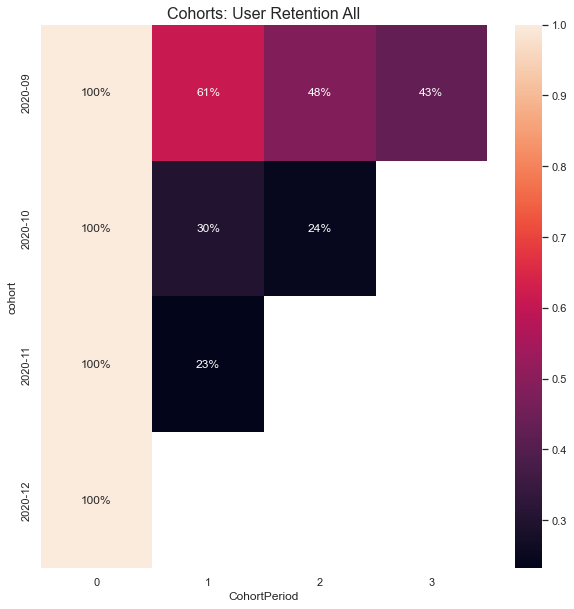

In [57]:
draw_retantion_diagram(df_merged, width=10, height=10, title='All');

In [58]:
df.groupby('event_date_month').count()

,event_date,user_id,product,amount,transactions,average_user_check
event_date_month,,,,,,
2020-09,26642,26642,26642,26642,26642,26642
2020-10,395315,395315,395315,395315,395315,395315
2020-11,412936,412936,412936,412936,412936,412936
2020-12,443293,443293,443293,443293,443293,443293


In [59]:
df_merged.groupby('cohort').count()

,event_date,user_id,product,amount,transactions,average_user_check,event_date_month
cohort,,,,,,,
2020-09,273180,273180,273180,273180,273180,273180,273180
2020-10,586271,586271,586271,586271,586271,586271,586271
2020-11,249811,249811,249811,249811,249811,249811,249811
2020-12,168924,168924,168924,168924,168924,168924,168924


In [60]:
len(df.user_id.unique())

446935

In [61]:
len(df.user_id)

1278186

In [62]:
273180+586271+249811+168924

1278186

In [63]:
#Средневзвешенный retention
(26642*61 + 395315*30 + 412936*23)/(1278186-443293)

27.527048376258993

Таким образом, имеем пратически 30% возвращаемость на следующий месяц - для транзакционного бизнеса это хороший показатель

### Статистики

In [65]:
d.describe()

,amount,transactions,average_user_check
count,92.000000,92.000000,92.000000
mean,238.119480,1.290673,185.765250
std,14.484433,0.022138,8.482832
min,209.426332,1.247277,168.997055
25%,223.691838,1.274199,176.064589
50%,239.266908,1.291465,188.222479
75%,249.827530,1.306771,192.315342
max,265.511771,1.341576,200.297201


In [66]:
d_b.describe()

,amount,transactions,average_user_check
count,92.000000,92.000000,92.000000
mean,163.273605,1.294849,127.379230
std,9.375113,0.022972,5.263459
min,146.879016,1.252591,116.750139
25%,153.704066,1.278688,122.396511
50%,165.007902,1.294068,128.712890
75%,168.471508,1.311463,130.767378
max,180.582095,1.347091,138.115947


In [67]:
d_b_counts['user_id'].describe()

count       92.000000
mean     10765.521739
std       1256.163298
min       8067.000000
25%       9988.500000
50%      10657.000000
75%      11679.500000
max      13702.000000
Name: user_id, dtype: float64

In [68]:
d_a.describe()

,amount,transactions,average_user_check
count,92.000000,92.000000,92.000000
mean,495.851239,1.276190,386.832121
std,33.409616,0.030316,20.146156
min,428.135783,1.215087,342.887822
25%,472.543390,1.256293,372.044092
50%,497.240459,1.271716,387.492803
75%,524.626224,1.297982,402.088547
max,564.571806,1.360403,424.074297


In [69]:
d_a_counts['user_id'].describe()

count      92.000000
mean     3127.804348
std       395.719382
min      2333.000000
25%      2929.750000
50%      3100.500000
75%      3436.000000
max      4153.000000
Name: user_id, dtype: float64

In [70]:
advanced_proportion_users['proportion'].describe()

count    92.000000
mean      0.224974
std       0.005688
min       0.211621
25%       0.220883
50%       0.225203
75%       0.229543
max       0.240961
Name: proportion, dtype: float64

In [71]:
d_month.describe()

,amount,transactions,average_user_check
count,4.000000,4.000000,4.000000
mean,450.624597,2.431036,351.988858
std,127.288584,0.690600,96.634338
min,260.777732,1.397139,207.334092
25%,436.377917,2.386093,345.435850
50%,508.032913,2.756486,397.927598
75%,522.279593,2.801429,404.480606
max,525.654830,2.814033,404.766144


Еще раз убеждаемся, что аномальных значений в наших данных нет.

### 2. Формализация гипотез

**Гипотеза 1**: *Дополнительное информирование об эффективности услуг будет стимулировать их покупку*.  

Метрики и статистики (так как мы собираемся далее применять t-test, то в качестве статистик будем использовать средние) от, которых ждем изменений:  

  * **метрика**: *количество активных пользователей (DAU, MAU)*.  **статистика**: среднее количество активных пользователей (дневное/месячное) в тестовой и контрольной группе за время эксперимента. Ожидаем, что это число будет расти, так как за счет информирования мы можем привлечь новых пользователей (узнают о нас за счет "сарафанного радио") или уже успевших уйти (вспомнят о нас или заинтересуются услугой); 
  * **метрика**: *retention*. **статистика**: среднее значение retention (месячный) в тестовой и контрольной группе за время эксперимента. Ожидаем, что будет расти, так как будем напоминать нашим пользователям о себе, тем самым увеличивая вероятность повторных покупок. Но для проведения эксперимента у нас слишком малый отрезок времени (мало данных), к тому же такой эксперимент будет очень долгим -> далее рассматривать retention не будем;
  * **метрика**: *количество транзакций*, **статистика**: среднее число транзакций пользователей в тестовой и контрольной группе за время проведения теста. Ждем от них увеличения, так как информированный пользователь, скорее всего, совершит покупку с большей вероятностью. Но смотреть только на транзакции нельзя, так как возможна ситуация, когда их число растет, но эти покупки малого размера -> бизнесу плохо, несмотря на положительное изменение этой метрики;
  * **метрика**: *средний чек*, **статистика**: среднее значение средних чеков пользователей в тестовой и контрольной группе за время проведения теста. Смотрим на эту метрику, чтобы решить проблему транзакций - ожидаем, что она может упасть (хотим чтобы ее падение было меньше роста числа транзакций, а если будет рост - то вообще ок);
  * **метрика**: *суммарные покупки*, **статистика**: среднее значение суммарных покупок пользователей в тестовой и контрольной группе за время проведения теста. Кажется, что можем смотреть на нее вместо одновременного отслеживания среднего чека и числа транзакций - если суммарные покупки растут, то это для нас хорошо (при этом нам неважно, возросли ли они за счет повышения частотности транзакций или за счет более крупных, но редких покупок). Ожидаем рост. Но и падение этой метрики не всегда плохо, ведь она может упасть за чет прихода новых пользователей, которые покупают в среднем меньше, но в совокупности приносят больше.
  

Ожидаемое изменение метрик в процентах.  
Так как в качестве информирования чаще всего используются смс\email и прочие рассылки, то будем коцентрироваться на них: 
  * **метрика**: *количество активных пользователей (DAU, MAU)*. В среднем письма открывают в 15-20% случаев ([источник](https://www.statista.com/statistics/625161/marketing-e-mail-open-rates-industry/)) - допустим 20%. Предположим, что мы можем взаимодействовать с 80% наших клиентов + у нас качественная рассылка и половина пользователей перейдет по ссылке, а также еще половина совершит целевое действие (совершит покупку): $20*0.8*0.5*0.5 = 4$% - примерно столько людей мы сможем привлечь. Вряд ли мы мы будем рассылать письма каждый день, поэтому значимого изменения DAU ждать не стоит, но MAU как раз может увеличиться на эти 4%. Если раньше не проводили подобных мероприятий - тогда будем наблюдать изначальный всплеск, который впоследствии будет затухать (увидим, если будем проводить эксперимент довольно долго);
  * **метрика**: *количество транзакций*. По данным имеем 2.43 транзакции в среднем за месяц. Благодаря информированию, 4% пользователей будет совершать как минимум на 1 покупку больше (на 40% больше среднего). Но в совокупности этот эффект будет мал: $3.43*0.04 + 2.43*0.96 = 2.47$ -> ожидаемый эффект: 1.6% - округлим до 2%;
  * **метрика**: *средний чек*. Сильно зависит от того, какая стоимость у услуг, про которые мы даем дополнительную информацию (если они дорогие, то повышаем средний чек, если дешевые - понижаем). Предположим, что услуги одинаковы по стоимости -> значимого изменения этой метрики ждать не будем;
  * **метрика**: *суммарные покупки*. Так как зависит от среднего чека и среднего числа транзакций за период, а средний чек не должен меняться, то ждем эффекта аналогичного эффекту транзакций (2%).

**Гипотеза 2**: *Повышение цены базового продукта должно стимулировать покупку продвинутого продукта*.  

То есть мы предполагаем, что, в идеальном случае, все пользователи, которые использовали базовый продукт переедут на продвинутый -> в пользователях мы не потеряем, а остальные метрики возрастут. Но такого не бывает...  
Метрики и статистики от, которых ждем изменений:
  * **метрика**: *количество активных пользователей (DAU, MAU)*. **статистика**: среднее количество активных пользователей (дневное/месячное) в тестовой и контрольной группе за время эксперимента. Увеличение цены - негатив для пользователя, они могут от нас уходить (не совершать покупки, которые сделали бы по прежней цене) - ожидаем падение (а оно зависит от размера увеличение цены, если поднимаем несильно, то пользователи могут и не заметить);
  * **метрика**: *количество транзакций*, **статистика**: среднее число транзакций пользователей продвинутого продукта в тестовой и контрольной группе за время проведения теста. Ожидаем рост. Тут мы уже не можем смотреть на средние тарнзакции по всем пользователям, так как наиболее вероятно, что пользователи будут перетекать от базового продукта к продвинутому (совершать больше транзакций в продвинутом продукте, и меньше в базовом), но мы этого не увидим, так как среднее не изменится. Хорошо бы еще смотреть на те же метрики по базовому продукту (следить за тем, чтобы они не упали слишком сильно, т.е. выигрыш для бизнеса за счет роста метрик продвинутого продукта был больше проигрыша от падения метрик базового продукта);
  * **метрика**: *средний чек*, **статистика**: среднее значение средних чеков пользователей продвинутого продукта в тестовой и контрольной группе за время проведения теста. Ожидаем падение. По тем же причинам, что и для транзакций необходимо смотреть метрики именно для продвинутого продукта. Схожая проблема - если пользователи начнут совершать мелкие покупки продвинутого продукта вместо объемных покупок базового продукта, то метрика упадет, хотя пользователи переходят на более дорогую модель, что хорошо -> не подходит для проверки данной гипотезы, не будем далее ее рассматривать;
  * **метрика**: *суммарные покупки*, **статистика**: среднее значение суммарных покупок пользователей продвинутого продукта в тестовой и контрольной группе за время проведения теста. Также ожидаем рост. По тем же причинам, что и для транзакций и среднего чека необходимо смотреть метрики именно для продвинутого продукта;
  * **метрика**: *доля продвинутого продукта*. **статистика**: среднее значение доли продвинутого продукта за каждый день эксперимента. Предполагаем, что все доли по продвинутому продукту (пользователей, транзакций, суммарных покупок) будут расти за счет перетока "базовых" пользователей. Однако, эта метрика может ввести в заблуждение - если вдруг мы повысим цены настолько, что пользователи базового продукта просто уйдут от нас (самый худший вариант), то все эти доли будут равны 1 -> далее не будем рассматривать их;
  * **метрика**: *retention*. **статистика**: среднее значение retention (месячный) для пользователей продвинутого продукта в тестовой и контрольной группе за время эксперимента. Предполагаем, что он будет расти, а retention базового продукта будет падать -> поэтому рассматриваем именно по продвинутому продукту. Но для проведения эксперимента у нас слишком малый отрезок времени (мало данных для эксперимента), к тому же такой эксперимент будет очень долгим -> далее рассматривать retention не будем.
  

Ожидаемое изменение метрик в процентах:
  * **метрика**: *количество активных пользователей (DAU, MAU)*. Данное изменение крайне сильно зависит от размера поднятия цен (чем больше оно будет, тем больше уйдет от нас клиентов). Допустим, что изменение может быть достаточно велико и от нас уйдут 10% пользователей (при этом это будут DAU\MAU базового продукта)
  * **метрика**: *количество транзакций*. Если от нас уходит 10% пользователей базового продукта, то для того чтобы покрыть убытки нам необходимо, чтобы среднее число транзакций в продвинутом продукте возросло на 10/3 ~ 3.3% (так как сумма покупок в продвинутом продукте примерно в 3 раза больше, чем в базовом). Это при сохранении значения DAU/MAU продвинутого продукта (а оно увеличится) и среднего чека продвинутого продукта (от перехода базовых пользователей может упасть, но мы только выиграем от перехода на более дорогую модель) -> нам нужен даже меньший эффект, чтобы окупить потери. Но кажется логичным, что можем рассчитывать на более заметный эффект - остановимся на 5%;
  * **метрика**: *средний чек*. По схожей с транзакциями логике, будем ждать 5% падение среднего чека по продвинутому продукту.;
  * **метрика**: *суммарные покупки*. Так как данная метрика учитывает в себе и транзакции и средний чек, то нас интересует гораздо меньший положительный эффект - остановимся на 3% .

### Предсказание минимально детектируемого эффекта 

**Гипотеза 1**: *Дополнительное информирование об эффективности услуг будет стимулировать их покупку*.  

В качестве метрики эксперимента сначала рассмотрим суммарные покупки, так как эта метрика объединяет в себе транзакции и средний чек, что позволяет следить только за ней. Так как эксперимент не несет для нас угрозы (не предполагаем риска при его проведении), то выберем стандартные значения уровня значимости и мощности: $\alpha=0.05, 1-\beta=0.8$, к тому же пользователей на тест и контроль можно разбить 50 на 50. Эффект от рассылок мы будем получать не сразу, а спустя некоторый временной лаг (пока пользователь получит сообщение, пока его прочитает, пока соберется купить и наконец купит), поэтому тест целесообразно проводить долго - для начала рассмотрим весь квартал (91 день). Заметим, что в наших данных имеется недельная сезонность - тест нужно проводить по неделям, иначе нельзя будет сделать общих выводов.   
Определим MDE в таком случае - будем подбирать его используя *tt_ind_solve_power* до тех пор пока соотношение групп не станет близким к 1:

In [405]:
def choose_date(data, start_date, delta, share): 
    tmp = data[(data.event_date>=start_date)&(data.event_date<=start_date+datetime.timedelta(days=delta))]
    tmp=tmp.groupby(['user_id']).sum().reset_index()
    x = tmp[(tmp.user_id)%100<=100*share].reset_index()
    return x

In [492]:
def calculate_mde(mean, std, alpha, power, n):
    effects = np.linspace(0.5, 0.001, num=1000)
    volums = []
    for i, effect in enumerate(effects):
        effect_size = (mean/std) * effect
        volums.append(tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')/n)
        if  volums[i] <= 1:
            mde = effect
    return mde, effects, volums

In [493]:
x1 = choose_date(df, datetime.datetime(2020, 9, 29, 0, 0), 91, 0.5) #получаем необходимую подвыборку
mean = x1.amount.mean()
std = x1.amount.std()
alpha = 0.05
power = 0.8
mde, effects, volums = calculate_mde(mean=mean, std=std, alpha=alpha, power=power, n=x1.shape[0])
mde

0.0514494494494494

Сама зависимость выглядит следующим образом:

Text(0, 0.5, 'Соотношение численностей групп')

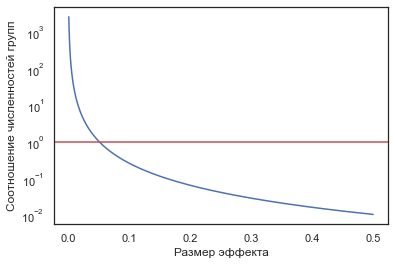

In [494]:
plt.yscale('log')
plt.plot(effects, volums);
plt.axhline(y=1, color='r');
plt.xlabel('Размер эффекта')
plt.ylabel('Соотношение численностей групп')

Таким образом, MDE = 0.051 оказался "великоват" (больше того эффекта, который мы планировали - 2%). Нужно менять параметры теста, чтобы иметь возможность зафиксировать планируемый эффект. Так как тест неопасен для нас - можем увеличить уровень знаимости $\alpha$ и уменьшить мощность $1-\beta$:

In [495]:
x1 = choose_date(df, datetime.datetime(2020, 9, 29, 0, 0), 91, 0.5) #получаем необходимую подвыборку
mean = x1.amount.mean()
std = x1.amount.std()
alpha = 0.1
power = 0.293
mde, effects, volums = calculate_mde(mean=mean, std=std, alpha=alpha, power=power, n=x1.shape[0])
mde

0.019980980980980945

В этом случае, мы уже сможем заметить эффект, если он будет иметь место (правда, лишь в ~ 30% случаев).
Попробуем взять в качестве метрики связку транзакций и среднего чека (проведем 2 теста): 

In [496]:
# тест с транзакциями
x1 = choose_date(df, datetime.datetime(2020, 9, 29, 0, 0), 91, 0.5) #получаем необходимую подвыборку
mean = x1.transactions.mean()
std = x1.transactions.std()
alpha = 0.05
power = 0.8
mde, effects, volums = calculate_mde(mean=mean, std=std, alpha=alpha, power=power, n=x1.shape[0])
mde

0.038961961961961944

In [498]:
# тест со средним чеком
x1 = choose_date(df, datetime.datetime(2020, 9, 29, 0, 0), 91, 0.5) #получаем необходимую подвыборку
mean = x1.average_user_check.mean()
std = x1.average_user_check.std()
alpha = 0.05
power = 0.8
mde, effects, volums = calculate_mde(mean=mean, std=std, alpha=alpha, power=power, n=x1.shape[0])
mde

0.029471471471471444

Как видим, оба теста являются более чувствительными по сравнению с тестом с суммарными покупками, но все еще не позволяют фиксировать ожидаемый нами эффект в 2%. Подберем параметры аналогичным образом:

In [508]:
# тест с транзакциями
x1 = choose_date(df, datetime.datetime(2020, 9, 29, 0, 0), 91, 0.5) #получаем необходимую подвыборку
mean = x1.transactions.mean()
std = x1.transactions.std()
alpha = 0.1
power = 0.4
mde, effects, volums = calculate_mde(mean=mean, std=std, alpha=alpha, power=power, n=x1.shape[0])
mde

0.019481481481481433

In [507]:
# тест со средним чеком
x1 = choose_date(df, datetime.datetime(2020, 9, 29, 0, 0), 91, 0.5) #получаем необходимую подвыборку
mean = x1.average_user_check.mean()
std = x1.average_user_check.std()
alpha = 0.1
power = 0.6
mde, effects, volums = calculate_mde(mean=mean, std=std, alpha=alpha, power=power, n=x1.shape[0])
mde

0.019980980980980945

Так как нам нужно находить эффект в 2 случаях, то совокупная мощность составит: $0.4*0.6=0.24$ (меньше, чем в тесте с суммарными покупками), к тому же будет вероятнее ошибка первого рода (false positive), да и вообще можно говорить про множественную проверку гипотез (при тесте хорошо бы скорректировать $\alpha$ методом Холма-Бонфферрони или другим), так что остановимся единичном тесте с суммарными покупками.

**Гипотеза 2**: *Повышение цены базового продукта должно стимулировать покупку продвинутого продукта.* 

В качестве метрики эксперимента возьмем транзакции по продвинутому продукту (тут можно рассматривать только их без учета среднего чека, так как переход к более дорогому продукту выгоден для нас даже если покупки будут меньшего объема). Так как эксперимент опасен (есть риск потери клиентов), то тут надо подстраховаться и выбрать уровень значимости поменьше, а мощность также взять стандартной: $\alpha=0.05, 1-\beta=0.8$, к тому же опасно использовать для теста всех пользователей (из тестовой группы мы будем терять людей) - возьмем для теста четверть. Эффект от поднятия цен будет виден сразу (с первого же для пользователи будут реагировать на изменение цены), поэтому тест целесообразно можно (и хорошо бы) делать как можно короче - начнем с 28 дней.   
Но сначала сравним MDE при тех же параметрах, что и для гипотезы 1:

In [432]:
# В тест будем набирать всех пользователей, 
# но будем группировать их действия по продукту  
def choose_date_with_advanced(data, start_date, delta, share):
    tmp = data[(data.event_date>=start_date)&(data.event_date<=start_date+datetime.timedelta(days=delta))]
    tmp = tmp.groupby(['user_id', 'product']).sum().reset_index()
    x = tmp[(tmp.user_id)%100<=100*share].reset_index()
    return x

In [436]:
x2 = choose_date_with_advanced(df, datetime.datetime(2020, 9, 29, 0, 0), 91, 0.5) #получаем необходимую подвыборку
mean = x2[x2['product'] == 'advanced'].transactions.mean()
std = x2[x2['product'] == 'advanced'].transactions.std()
alpha = 0.05
power = 0.8
mde, effects, volums = calculate_mde(mean=mean, std=std, alpha=alpha, power=power, n=x2.shape[0])
mde

0.03846246246246243

Видим, что разница невелика но все-таки 2-ой тест немного мощнее.  
Теперь замерим MDE при обозначенных параметрах:

In [437]:
x2 = choose_date_with_advanced(df, datetime.datetime(2020, 9, 29, 0, 0), 28, 0.25) #получаем необходимую подвыборку
mean = x2[x2['product'] == 'advanced'].transactions.mean()
std = x2[x2['product'] == 'advanced'].transactions.std()
alpha = 0.01
power = 0.8
mde, effects, volums = calculate_mde(mean=mean, std=std, alpha=alpha, power=power, n=x2.shape[0])
mde

0.06843243243243241

Видим, что MDE снова оказался гораздо больше предполагаемого эффекта - попробуем изменить параметры (т.к. наш эксперимент рисковый, можем безопасно менять только мощность):

In [467]:
x2 = choose_date_with_advanced(df, datetime.datetime(2020, 9, 29, 0, 0), 28, 0.25) #получаем необходимую подвыборку
mean = x2[x2['product'] == 'advanced'].transactions.mean()
std = x2[x2['product'] == 'advanced'].transactions.std()
alpha = 0.01
power = 0.47
mde, effects, volums = calculate_mde(mean=mean, std=std, alpha=alpha, power=power, n=x2.shape[0])
mde

0.04995095095095092

Таким образом, сможем увидеть ожидаемый эффект в чуть менее половины случаев, когда он действительно имеет место быть.

### Выбор оптимального плана
Глобально у нас есть 2 пути для проведения тестов по проверке первой и второй продуктовых гипотез:
  - проводить их последовательно; 
  - проводить параллельно.
  
*Последовательный* способ позволяет задействовать в тестах всех пользователей (для нас это не так актутально, так как в рисковом тесте мы не будем задействовать всех пользователей), но ограничивает по времени - в нашем случае мы не успеем провести 2 теста друг за другом (на 1 из них (неопасный) нужен весь квартал), поэтому придется еще более снижать чувствительность этого теста.  
*Параллельный* же способ как раз и предоставляет возможность не менять сроки проведения теста (проводим тесты одновременно), но так как пользователи не должны пересекаться, то накладывается ограничение на размеры самих групп, что чаще всего сильнее снижает чувствительность.  
Для выбора оптимального плана замерим, как нужно изменить параметры, чтобы обеспечить нахождение MDE при той же мощности:

In [513]:
# для последовательного способа уменьшаем время проведения теста:
# (91 (общее кол-во дней) - 28 (время проведения опасного теста) = 63)
x1 = choose_date(df, datetime.datetime(2020, 9, 29, 0, 0), 63, 0.5) #получаем необходимую подвыборку
mean = x1.amount.mean()
std = x1.amount.std()
alpha = 0.1
power = 0.281
mde, effects, volums = calculate_mde(mean=mean, std=std, alpha=alpha, power=power, n=x1.shape[0])
mde

0.019980980980980945

In [525]:
# для параллельного способа уменьшаем долю пользователей:
# половина пользователей занята в опасном тесте - придется обойтись другой половиной 
x1 = choose_date(df, datetime.datetime(2020, 9, 29, 0, 0), 91, 0.25) #получаем необходимую подвыборку
mean = x1.amount.mean()
std = x1.amount.std()
alpha = 0.1
power = 0.193
mde, effects, volums = calculate_mde(mean=mean, std=std, alpha=alpha, power=power, n=x1.shape[0])
mde

0.019481481481481433

Таким образом, видим, что при последовательном плане мы теряем меньше мощности -> он будет оптимальным для нас.

### Оптимизация плана
1. Можем сначала проводить опасный тест, следя параллельно за DAU/MAU в тестовой группе - если заметим сильное падение, то сразу же остановим тест, отвергнем гипотезу и начнем другой тест (неопасный) с сэкономленным временем (или повысим чувствительность неопасного теста).
2. Если каким-либо образом увеличим число наших клиентов, тем самым поднимем чувствительность наших тестов или сможем проводить их быстрее (но если это новые клиенты, то они могут сильно изменить само распределение и просадить метрику транзакций, например, если совершат 1 покупку и уйдут).
3. Если говорить конкретно о времени, то все еще можем повышать $\alpha$, снижать мощность, увеличивать долю пользователей, участвующих в эксперименте, но это ведет к дополнительному риску принятия неправильного решения (особенно плохо для опасного теста).